In [77]:
from fastbook import *
from fastai.vision.widgets import *
from PIL import Image

In [88]:
from fastai.basics import load_learner

In [81]:
import fastai
fastai.__version__

'2.1.8'

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '73054b9ab75e462e81e11f32920fa489')

In [2]:
fruits = ['peach','orange','apple','banana',\
          'pear', 'watermelon', 'mango', 'avocado',\
          'cherry', 'grapes', 'kiwi', 'pineapple',
         'strawberry']
path = Path('fruits')

In [11]:
if not path.exists():
    path.mkdir()
    for o in fruits:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} fruit', max_images=300)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [36]:
# Double check
fns = get_image_files(path)
fns

(#1821) [Path('fruits/grapes/00000058.jpg'),Path('fruits/grapes/00000049.jpg'),Path('fruits/grapes/00000125.jpg'),Path('fruits/grapes/00000078.jpg'),Path('fruits/grapes/00000076.jpg'),Path('fruits/grapes/00000089.jpg'),Path('fruits/grapes/00000010.jpg'),Path('fruits/grapes/00000110.JPG'),Path('fruits/grapes/00000106.jpg'),Path('fruits/grapes/00000100.jpg')...]

In [18]:
failed = verify_images(fns) # check docstring
failed # try openning these file in the browser yourself

(#0) []

In [19]:
# remove corrupted images
failed.map(Path.unlink)

(#0) []

In [53]:
def png_to_jpg(paths):
    paths = [i for i in paths if str(i).endswith('.png')]
    for img_path in paths:
#         print(img_path)
        png = Image.open(img_path)
        png = png.convert('RGB')
        png.save(str(img_path)[:-3] + 'jpg', 'JPEG', quality=80)

In [54]:
fns = get_image_files(path)
png_to_jpg(fns)

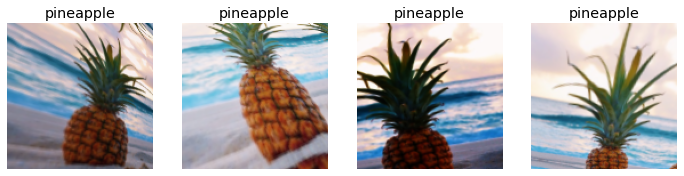

In [55]:
fruits = DataBlock(
    # simply tells DataBlock that we have image as input and Category as label
    blocks=(ImageBlock, CategoryBlock), 
    # which function to retreive image filename
    get_items=get_image_files, 
    # train-val split
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # label using the parent folder
    get_y=parent_label,
    # resize each image to 128x128
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2)
)

dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [56]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.858835,1.064507,0.317680,00:30


epoch,train_loss,valid_loss,error_rate,time
0,1.509535,0.791271,0.256906,00:24
1,1.284207,0.661415,0.226519,00:23
2,1.093525,0.602382,0.204420,00:23
3,0.942188,0.572646,0.179558,00:24


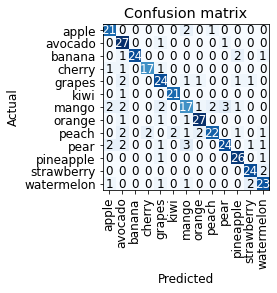

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

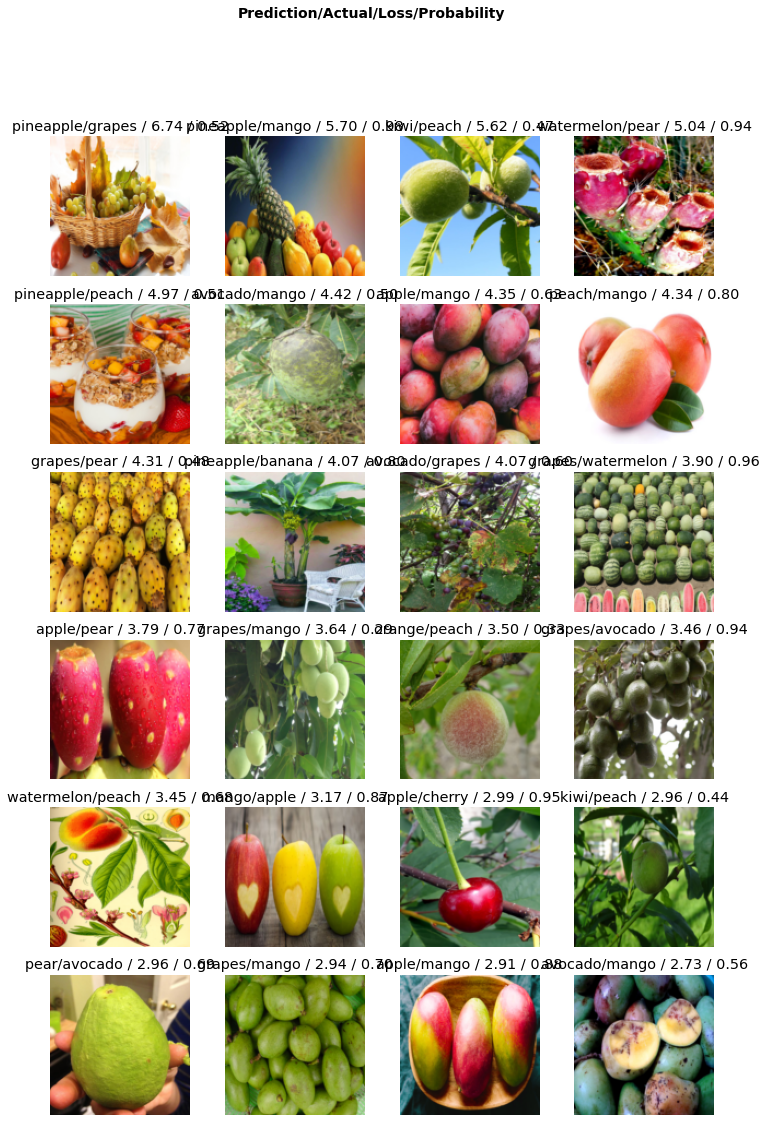

In [58]:
interp.plot_top_losses(24, nrows=6)

In [59]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [52]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# move images for which we've selected a different category
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [60]:
learn.export(fname='fruits.pkl')
learn_if = load_learner('fruits.pkl')
learn_if.predict('fruits/banana/00000003.jpeg')

('banana',
 tensor(2),
 tensor([4.1205e-06, 3.3154e-05, 9.9981e-01, 9.4265e-07, 3.7404e-06, 3.7093e-07, 2.5341e-05, 1.7306e-07, 4.9073e-05, 5.9358e-05, 2.9399e-06, 3.5278e-07, 1.0886e-05]))

In [61]:
from PIL import Image
example = Image.open('fruits/banana/00000003.jpeg')

In [76]:
from numpy import array as a
learn_if.predict(a(example))[0]

'banana'

In [68]:
vocab = learn_if.dls.vocab
dict(zip(vocab, range(len(vocab))))

{'apple': 0,
 'avocado': 1,
 'banana': 2,
 'cherry': 3,
 'grapes': 4,
 'kiwi': 5,
 'mango': 6,
 'orange': 7,
 'peach': 8,
 'pear': 9,
 'pineapple': 10,
 'strawberry': 11,
 'watermelon': 12}